In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(0)

# generate dataset
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=8,
    n_redundant=2,
    n_classes=5,
    n_clusters_per_class=1,
    random_state=42
)

# normalize input data
X = (X - X.mean(axis=0)) / X.std(axis=0)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Classes:", np.unique(y))


X shape: (1000, 10)
y shape: (1000,)
Classes: [0 1 2 3 4]


In [11]:
def one_hot(y, num_classes=5):
    oh = np.zeros((y.shape[0], num_classes))
    oh[np.arange(y.shape[0]), y] = 1
    return oh

Y = one_hot(y, 5)

X_train, X_test, Y_train, Y_test, y_train_cls, y_test_cls = train_test_split(
    X, Y, y, test_size=0.3, random_state=42, stratify=y
)


In [10]:
class NeuralNetwork:
    def __init__(self, input_dim, h1, h2, h3, output_dim, lr=0.001):
        self.lr = lr

        # better initialization
        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2/input_dim)
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * np.sqrt(2/h1)
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * np.sqrt(2/h2)
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, output_dim) * np.sqrt(2/h3)
        self.b4 = np.zeros((1, output_dim))

    # ReLU
    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    # Softmax
    def softmax(self, z):
        z_shift = z - np.max(z, axis=1, keepdims=True)
        exp_val = np.exp(z_shift)
        return exp_val / np.sum(exp_val, axis=1, keepdims=True)

    # Forward pass
    def forward(self, X):
        self.X = X

        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)

        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.relu(self.z2)

        self.z3 = self.a2 @ self.W3 + self.b3
        self.a3 = self.relu(self.z3)

        self.z4 = self.a3 @ self.W4 + self.b4
        self.y_hat = self.softmax(self.z4)

        return self.y_hat

    # Cross entropy loss
    def loss(self, Y_true):
        eps = 1e-10
        return -np.mean(np.sum(Y_true * np.log(self.y_hat + eps), axis=1))

    # Backpropagation
    def backward(self, Y):
        m = Y.shape[0]

        dz4 = (self.y_hat - Y) / m
        dW4 = self.a3.T @ dz4
        db4 = np.sum(dz4, axis=0, keepdims=True)

        dz3 = (dz4 @ self.W4.T) * self.relu_derivative(self.z3)
        dW3 = self.a2.T @ dz3
        db3 = np.sum(dz3, axis=0, keepdims=True)

        dz2 = (dz3 @ self.W3.T) * self.relu_derivative(self.z2)
        dW2 = self.a1.T @ dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)

        dz1 = (dz2 @ self.W2.T) * self.relu_derivative(self.z1)
        dW1 = self.X.T @ dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        # update
        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def train_step(self, X, Y):
        pred = self.forward(X)
        L = self.loss(Y)
        self.backward(Y)
        return L

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)


Epoch 200 Loss = 1.5670
Epoch 400 Loss = 1.4563
Epoch 600 Loss = 1.3743
Epoch 800 Loss = 1.3012
Epoch 1000 Loss = 1.2337
Epoch 1200 Loss = 1.1634
Epoch 1400 Loss = 1.0923
Epoch 1600 Loss = 1.0232
Epoch 1800 Loss = 0.9587
Epoch 2000 Loss = 0.9002


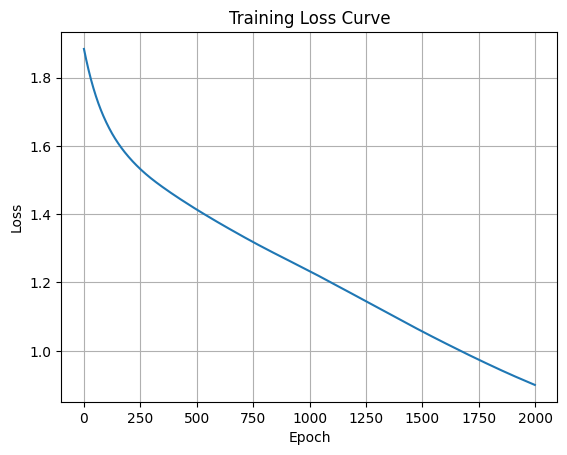

In [12]:
nn = NeuralNetwork(
    input_dim=10,
    h1=64,
    h2=32,
    h3=16,
    output_dim=5,
    lr=0.001
)

epochs = 2000
loss_list = []

for ep in range(epochs):
    L = nn.train_step(X_train, Y_train)
    loss_list.append(L)

    if (ep+1) % 200 == 0:
        print(f"Epoch {ep+1} Loss = {L:.4f}")

plt.plot(loss_list)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [14]:
y_pred = nn.predict(X_test)

print(classification_report(y_test_cls, y_pred))

cm = confusion_matrix(y_test_cls, y_pred)
print(cm)


              precision    recall  f1-score   support

           0       0.60      0.68      0.64        60
           1       0.73      0.68      0.71        60
           2       0.84      0.63      0.72        60
           3       0.68      0.67      0.67        60
           4       0.58      0.70      0.64        60

    accuracy                           0.67       300
   macro avg       0.69      0.67      0.68       300
weighted avg       0.69      0.67      0.68       300

[[41  1  1  9  8]
 [ 6 41  1  2 10]
 [ 4  6 38  7  5]
 [ 4  4  5 40  7]
 [13  4  0  1 42]]


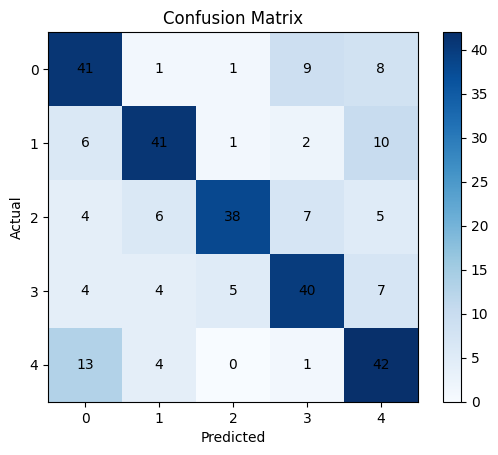

In [15]:
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

for i in range(5):
    for j in range(5):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
